In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
from plotting import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit
from sklearn.metrics import mean_squared_error

In [ ]:
%%time
# ~18mins

# Execute CURATE without pop tau
execute_CURATE()

In [ ]:
%%time
# Perform CV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_CV()
execute_CURATE_and_update_pop_tau_results('CV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

# Perform LOOCV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_LOOCV()
execute_CURATE_and_update_pop_tau_results('LOOCV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

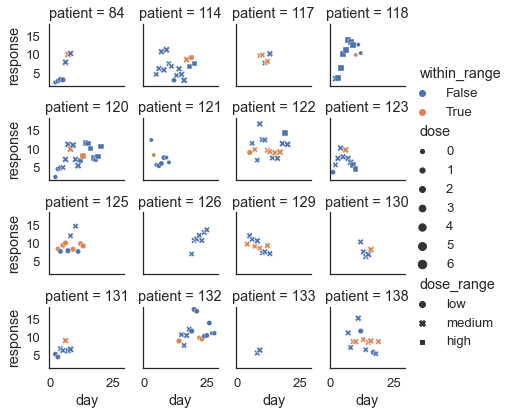

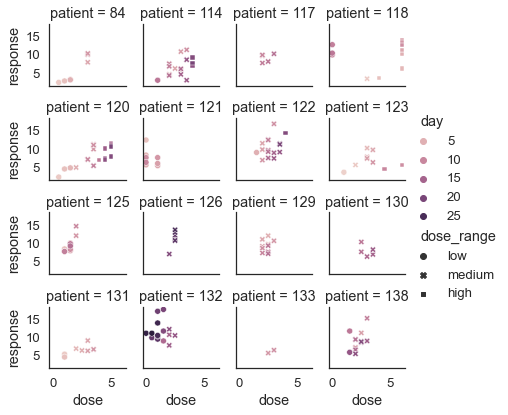

In [88]:
# Plot individual profiles
dat = pd.read_excel('output (with pop tau by LOOCV).xlsx', sheet_name='clean')

# Create within-range column
dat['within_range'] = (dat.response <= 10) & (dat.response >= 8)

# Create low/med/high dose column
dat['dose_range'] = ""
for i in range(len(dat)):
    if dat.dose[i] < 2:
        dat.loc[i, 'dose_range'] = 'low'
    elif dat.dose[i] < 4:
        dat.loc[i, 'dose_range'] = 'medium'
    else:
        dat.loc[i, 'dose_range'] = 'high'
        
# dat
# # dat
sns.set(font_scale=1.2)
sns.set_style('white')

sns.relplot(data=dat, x='day', y='response', size='dose', hue='within_range', col='patient', col_wrap=4, style='dose_range',
           height=1.5, aspect=1)

plt.savefig('indiv_pt_profile_by_day.png', dpi=500, facecolor='w', bbox_inches='tight')

sns.set(font_scale=1.2)
sns.set_style('white')

sns.relplot(data=dat, x='dose', y='response', hue='day', col='patient', col_wrap=4, style='dose_range',
           height=1.5, aspect=1)

plt.savefig('indiv_pt_profile_by_dose.png', dpi=500, facecolor='w', bbox_inches='tight')

In [ ]:
dat = df.copy()
dat

In [ ]:
%%time 
df = can_benefit_SOC_predictions(file_string='output (with pop tau by LOOCV).xlsx')

In [2]:
df = read_file_and_remove_unprocessed_pop_tau(file_string='output (with pop tau by LOOCV).xlsx')




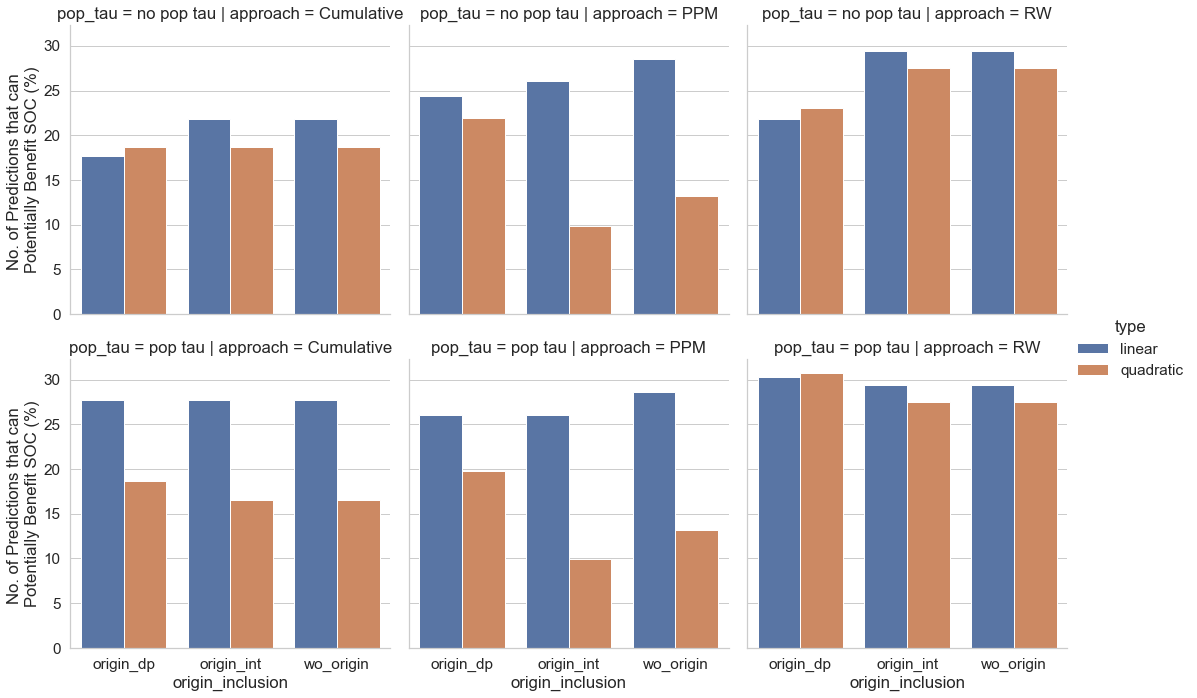

In [33]:
dat = can_benefit_SOC_predictions(file_string='output (with pop tau by LOOCV).xlsx')

Wall time: 26.9 s


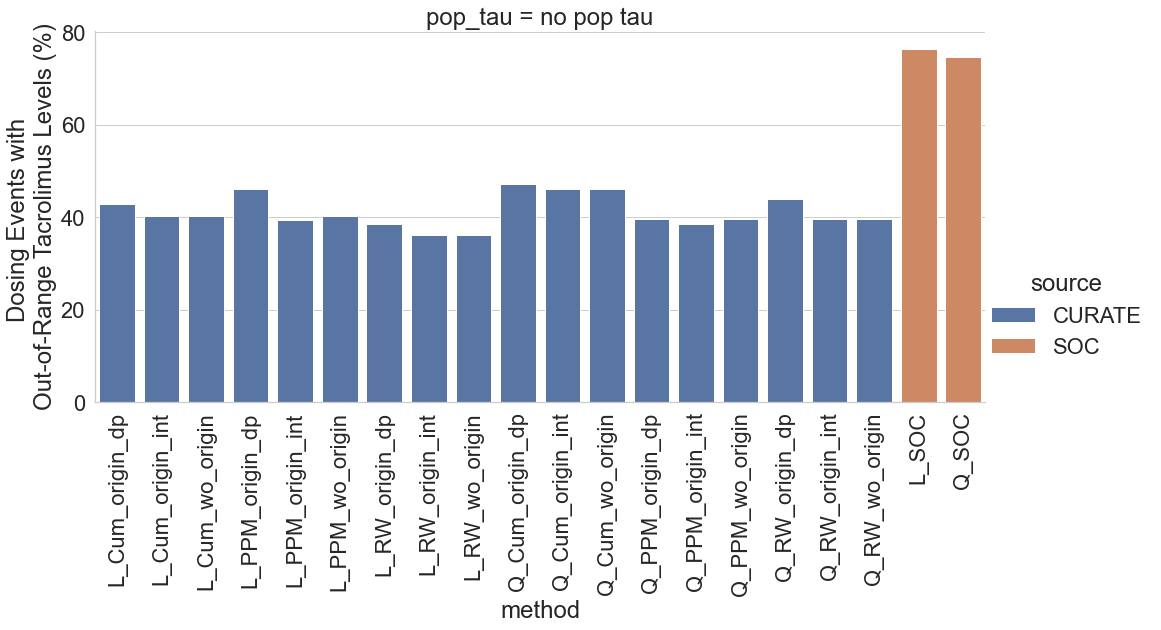

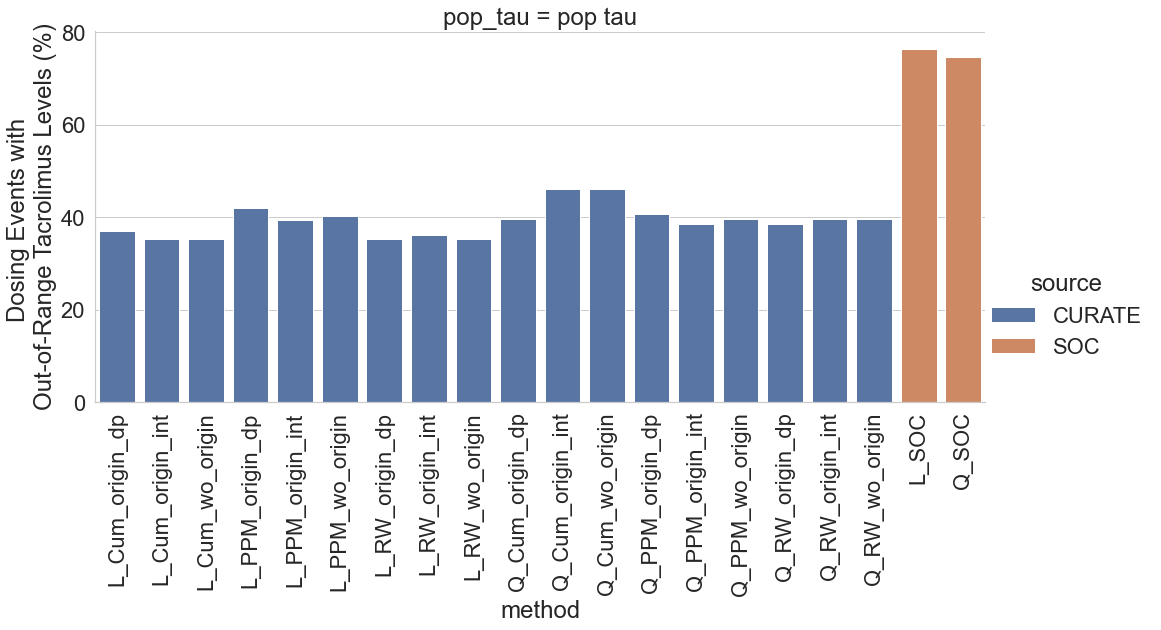

In [36]:
%%time
dat = OOR_predictions(file_string='output (with pop tau by LOOCV).xlsx')

In [50]:
df = dat.copy()
df = df[df.pop_tau=='no pop tau'].reset_index(drop=True)

# Add 'type' column
for i in range(len(df)):
    if 'L' in df.method[i]:
        df.loc[i, 'type'] = 'linear'
    else:
        df.loc[i, 'type'] = 'quadratic'

df[df.source=='CURATE'].groupby('type')['wrong_range'].describe()
# df
# df[df.source=='CURATE'].wrong_range.describe()
# df

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
linear,9.0,40.056022,3.144250,36.134454,38.655462,40.336134,40.336134,46.218487
quadratic,9.0,42.246642,3.565554,38.461538,39.560440,39.560440,46.153846,47.252747


In [30]:
pd.set_option('display.max_rows', None)

dat = df.copy()

dat = dat[['patient', 'method', 'pred_day', 'dose', 'response', 'coeff_2x', 'coeff_1x', 'coeff_0x', 'prediction', 'deviation']]


# Find percentage of predictions where both observed and prediction response are outside range
# dat['acceptable_deviation'] = ""
for i in range(len(dat)):
    dat.loc[i, 'both_outside'] = False
    if (dat.loc[i, 'prediction'] > 10) or (dat.loc[i, 'prediction'] < 8):
        if (dat.loc[i, 'response'] > 10) or (dat.loc[i, 'response'] < 8):
            dat.loc[i, 'both_outside'] = True

    # if (dat.deviation[i] > -2) and (dat.deviation[i] < 1.5):
    #     dat.loc[i, 'acceptable_deviation'] = True
    # else: dat.loc[i, 'acceptable_deviation'] = False
dat['acceptable_deviation'] = (round(dat['deviation'],2) >= -2) & (round(dat['deviation'],2) <= 1.5)

dat['can_benefit'] = dat['acceptable_deviation'] & dat['both_outside']

dat = dat[(dat.method=='Q_RW_wo_origin') | (dat.method=='Q_RW_wo_origin_pop_tau')]

# dat = dat[dat.patient==120]

# dat = dat.groupby(['method', 'patient'])['can_benefit'].sum()
# dat = dat.reset_index()

# If can correctly identify out of range, with acceptable deviation, can benefit
dat = dat.groupby(['method'])['can_benefit'].apply(lambda x: x.sum()/x.count() * 100).reset_index()

dat

# print(f"{dat.loc[1523,'deviation']} | {dat.loc[1539,'deviation']}")

,method,can_benefit
0,Q_RW_wo_origin,28.571429
1,Q_RW_wo_origin_pop_tau,28.571429


In [ ]:
dat = df.copy()
dat

In [ ]:
df = RMSE_plot(file_string='output (with pop tau by LOOCV).xlsx')

df = df[['OG_method', 'pop_tau', 'rmse']].set_index(['OG_method', 'pop_tau'])
df = df.unstack()
df.columns = ['no pop tau', 'pop tau']

# Set style for seaborn plot
sns.set(style="whitegrid", font_scale=1.4)

fig, ax = plt.subplots()

# Create stacked bar chart
df.plot(kind='bar', stacked=True, label=['no pop tau, pop tau'], ax=ax)

# Label, title, legend
plt.xlabel(None)
plt.ylabel('RMSE')
plt.title('RMSE')
# ax.legend(['no pop tau', 'pop tau'], bbox_to_anchor=(1.1,0.5), loc='center right')
ax.legend(['no pop tau', 'pop tau'])
plt.savefig('RMSE.png', bbox_inches='tight', dpi=300, facecolor='w')

return df

In [ ]:
%%time
prediction_error(file_string='output (with pop tau by LOOCV).xlsx')

In [ ]:
df = read_file_and_remove_unprocessed_pop_tau('output (with pop tau by LOOCV).xlsx')

In [ ]:
pd.set_option('display.max_rows', None)

dat = df.copy()
dat = dat[['method', 'patient', 'coeff_2x', 'coeff_1x', 'coeff_0x', 'half_life', 'deviation', 'abs_deviation']]

# dat.groupby(['method'])['abs_deviation'].median()

# dat[(dat.method == 'Q_PPM_origin_int') | (dat.method == 'Q_PPM_origin_int_pop_tau')].groupby(['method', 'patient'])['abs_deviation'].median()

dat[(dat.method == 'Q_PPM_origin_int') | (dat.method == 'Q_PPM_origin_int_pop_tau')]

In [ ]:
from Profile_Generation import *
from plotting import *

df = read_file_and_remove_unprocessed_pop_tau()

In [ ]:
df = pd.read_excel('GOOD OUTPUT DATA\output (with pop tau by LOOCV).xlsx', sheet_name='result')

In [ ]:
dat = df.copy()
# Keep all methods in dataframe except strictly tau methods (contains 'tau' but does not contain 'pop')
method_list = dat.method.unique().tolist()
exclude_method_list = [x for x in method_list if (('tau' in x) and ('pop' not in x))]
method_list = [x for x in method_list if x not in exclude_method_list]
dat = dat[dat.method.isin(method_list)]
dat = dat.reset_index(drop=True)

num_pred_linear = dat[dat.method=='L_Cum_wo_origin'].prediction.count()
num_pred_quad = dat[dat.method=='Q_Cum_wo_origin'].prediction.count()

print(f'num_pred_linear {num_pred_linear} | num_pred_quad {num_pred_quad}')

In [ ]:
dat = df.copy()

# Keep all methods in dataframe except strictly tau methods (contains 'tau' but does not contain 'pop')
method_list = dat.method.unique().tolist()
exclude_method_list = [x for x in method_list if (('tau' in x) and ('pop' not in x))]
method_list = [x for x in method_list if x not in exclude_method_list]
dat = dat[dat.method.isin(method_list)]
dat = dat.reset_index(drop=True)

# Create column for cond_1 where both predicted and observed values are out-of-range
dat['cond_1'] = ((dat.prediction < 8) | (dat.prediction > 10)) & ((dat.response < 8) | (dat.response > 10))

# Create column for cond_2 where prediction error is between -3 and +1
dat['cond_2'] = (dat.deviation > -3) & (dat.deviation < 1)

# Interpolate for 8, 9, 10mg
for i in range(len(dat)):
    # Create function
    coeff = dat.loc[i, 'coeff_2x':'coeff_0x'].apply(float).to_numpy()
    coeff = coeff[~np.isnan(coeff)]
    p = np.poly1d(coeff)
    x = np.linspace(0, 9)
    y = p(x)
    order = y.argsort()
    y = y[order]
    x = x[order]

    dat.loc[i, 'interpolated_dose_8'] = np.interp(8, y, x).tolist()
    dat.loc[i, 'interpolated_dose_9'] = np.interp(9, y, x).tolist()
    dat.loc[i, 'interpolated_dose_10'] = np.interp(10, y, x).tolist()

# dat[['coeff_2x', 'coeff_1x', 'coeff_0x', 'interpolated_dose_8','interpolated_dose_9','interpolated_dose_10']].describe()
# dat[['prediction', 'response', 'deviation', 'cond_1', 'cond_2']]
# dat
'interpolated_dose_8'


In [ ]:
np.iscomplex(dat.interpolated_dose_10).sum()

In [ ]:
import numpy as np
a = 2.881250
b = -0.121875
# c = -16.252151

x = 3.513015
a*x + b

# a*np.square(x) + b*x + c


In [ ]:
dat = pd.read_excel('GOOD OUTPUT DATA\output (with pop tau by LOOCV).xlsx', sheet_name='result')

# Keep all methods in dataframe except strictly tau methods (contains 'tau' but does not contain 'pop')
method_list = dat.method.unique().tolist()
exclude_method_list = [x for x in method_list if (('tau' in x) and ('pop' not in x))]
method_list = [x for x in method_list if x not in exclude_method_list]
dat = dat[dat.method.isin(method_list)]
dat = dat.reset_index(drop=True)

# Find RMSE by method
def rmse(dat):
    rmse = mean_squared_error(dat.response, dat.prediction, squared=False)
    return pd.Series(dict(rmse=rmse))

dat = dat.groupby('method').apply(rmse).reset_index()

# Create pop tau column and remove 'pop_tau' from method name
dat['pop_tau'] = ""
dat['OG_method'] = ""
for i in range(len(dat)):
    if 'pop_tau' in dat.method[i]:
        dat.loc[i, 'pop_tau'] = 'pop tau'
        dat.loc[i, 'OG_method'] = dat.loc[i, 'method'][:-8]
    else: 
        dat.loc[i, 'pop_tau'] = 'no pop tau'
        dat.loc[i, 'OG_method'] = dat.loc[i, 'method']

# Line plot of RMSE for pop tau and non pop tau
plt.figure(figsize=(15,10))
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# sns.lineplot(data=dat, x='OG_method', y='rmse', hue='pop_tau', marker='o', ax=ax)
# sns.lineplot(data=dat, x='OG_method', y='rmse', hue='pop_tau', marker='o', ax=ax2)

ax = sns.catplot(data=dat, x='OG_method', y='rmse', hue='pop_tau', ax=ax, kind='bar')
ax2 = sns.catplot(data=dat, x='OG_method', y='rmse', hue='pop_tau', ax=ax2, kind='bar')

ax2.set_ylim([min(dat.rmse), 12])
ax.set_ylim([np.exp(12), max(dat.rmse)+np.exp(12)])

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
# ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.set_ylabel(None)
ax2.set_ylabel('RMSE', loc='top')
ax2.set_xlabel(None)
ax2.get_legend().remove()
plt.xticks(rotation=90)

# Save
plt.savefig('RMSE.png', bbox_inches='tight', dpi=300, facecolor='w')

In [ ]:
# How are the predictions different, between different half-lives, for each method compared to without tau?
# Plot prediction vs prediction day, for each patient, colored by tau with different half-lives vs non-tau

dat = result_df.copy()
dat = dat[['prediction', 'pred_day', 'half_life', 'method', 'patient', 'deviation']]
patient_list = dat.patient.unique()
method_list = dat.method.unique()
dat = dat[dat.patient == patient_list[6]]
dat.half_life = dat.half_life.fillna(0)
# L_Cum_origin_dp_tau
palette = sns.color_palette("rocket_r", n_colors=len(dat.half_life.unique()))
# a = np.arange(3.5, 41.5, 1)
# dat.half_life.unique()
sns.lineplot(data=dat[dat.method.str.contains("L_RW_origin_dp")], 
             x="pred_day", y="deviation", hue="half_life", 
             palette=palette, ci=None)
plt.legend(bbox_to_anchor=(1.25,1), loc='upper right')
# plt.plot(data=dat[dat.method == "L_Cum_origin_dp_tau"], 
#          x="pred_day", y="prediction", color="half_life".map())

In [ ]:
dat = result_df.copy()
dat = dat[['deviation', 'method', 'patient', 'pred_day', 'response', 'prediction', 'half_life']]
dat['half_life'] = dat['half_life'].fillna('')
dat = dat.loc[(dat.method == 'Q_Cum_origin_dp_tau') | (dat.method == 'Q_Cum_origin_dp')]
dat['new_method'] = ""
for i in range(len(dat)):
    dat['new_method'].iloc[i] = dat['method'].iloc[i] + '_' + str(dat['half_life'].iloc[i])
    # print(dat['method'].iloc[i])
plot = sns.lineplot(data=dat, x="patient", y="deviation", hue="new_method", ci=None, legend=False)
plot = sns.lineplot(data=dat.loc[dat.method=='Q_Cum_origin_dp_ '], x="patient", y="deviation", color='b', ci=None, legend=False)
# dat.head()

# sns.lineplot(data=dat.loc[dat.patient==84], x="pred_day", y="deviation", hue="method")

# dat

In [ ]:
# Plotting
# perc_days_within_target_tac(result_df)
# perc_days_outside_target_tac(result_df)
# median_perc_within_acc_dev(result_df)
# can_benefit(result_df)
# modified_TTR(result_df)
# wrong_range(result_df)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import math

d = {'dose': [0.5, 1, 1.5, 1.5, 3, 3], 'response': [2.4, 2.8, 3.2, 3.1, 7.9, 10]}
df = pd.DataFrame(data=d)

# Calculate weight
j = 0
decay_weight = []
for i in range(len(df)):
    decay_weight.append(math.exp(-(24*(i))/(12/np.log(2))))

# Fit model
poly_reg = PolynomialFeatures(degree=2)
X = np.array(df.dose).reshape(-1, 1)
y = np.array(df.response)
X = poly_reg.fit_transform(X)
result = LinearRegression(fit_intercept=False).fit(X, y, decay_weight)
result.coef_
# new = 3
# prediction = result.predict(poly_reg.fit_transform([[new]]))[0]
# prediction

In [ ]:
np.array(3).reshape(-1, 1)

In [ ]:
a = pd.DataFrame(columns=['col1','col2'])
a = a[0:0]
a.loc[2, :] = [1, 2]

b = pd.DataFrame(columns=['col1','col2'])
b = b[0:0]
b.loc[0, :] = [1, 2]
b.loc[1, :] = [1, 2]

pd.concat([a, b])

In [ ]:
hello = ""
if hello:
    print('not empty')
else: print('empty')

In [ ]:
cols = ['a','b']
list_of_series = [pd.Series([1,2],index=cols), pd.Series([3,4],index=cols)]
df = pd.DataFrame(list_of_series, columns=cols)
df = pd.DataFrame(columns=cols)
df